## Project 1
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

We can bulid a search query to pull all cocktail names (`strDrink`), the ingredients for each, and the drink categories (`strCategory`) for each cocktail.

First, we get all drinks, by first letter of name.

In [2]:
import networkx as net
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

In [3]:
baseUrl = "https://www.thecocktaildb.com/api/json/v1/1/"
letterEndpoint = "search.php?f="

def searchLetter(letter):
    data = requests.get(baseUrl + letterEndpoint + letter)
    return json.loads(data.text)

In [4]:
# Build a dataframe
name = []  # drink name
ids = []   # drink ID
cat = []   # drink category
pic = []   # thumbnail url
ingr = []  # ingredients

In [5]:
# Helper function to parse ingredients
def ingreds(drinkDict):
    ing = []
    for i in range(1,16):  # API has 16 fields for ingredients of each drink, most of them empty/None
        s = "strIngredient" + str(i)
        if not d[s]:
            break
        ing.append(d[s])
    return ing

As we iterate through the letters, we make drinks Upper Case to distinguish from Ingredients, which may share the same name.

In [6]:
for l in 'abcdefghijklmnopqrstuvwxyz':
    
    drinks = searchLetter(l)['drinks']
    if not drinks: continue   #(some letters have no drinks)
    for d in drinks:
        name.append(str.upper(d['strDrink']))
        ids.append(d['idDrink'])
        cat.append(d['strCategory'])
        pic.append(d['strDrinkThumb'])
        ingr.append([str.lower(i) for i in ingreds(d)]) 

In [7]:
drinkDF = pd.DataFrame({'name': name,
                       'id': ids,
                       'category': cat,
                       'photoURL': pic,
                       'ingredients': ingr})
drinkDF.head()

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grand marnier, lemon juice, grenadine]"
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[amaretto, baileys irish cream, cognac]"
2,ACE,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[gin, grenadine, heavy cream, milk, egg white]"
3,ADAM,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[dark rum, lemon juice, grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[absolut vodka, gin, tonic water]"


Here's what the graph looks like unimodally.  The nodes are colored darker for higher degree centrality, and a quick zoom in shows that the darkest nodes are all ingredients, as opposed to drinks.  This is intuitive, since the normal number of ingredients in a single drink is perhaps 3 or 4, whereas the degree of an ingredient like vodka is only bounded by the number of drinks you add to the network.  Savvy tipplers may also notice the high centrality of gin, compared to vodka and others, which arises from the Anglo-centric nature of the data source.

In [8]:
from IPython.display import IFrame
IFrame('https://ebhtra.github.io/gory-graph/allDrinksIngreds/network', width=1000, height=1000)

### Bipartite Projections

In order to make our analysis more interesting, we can make a bipartite graph, with cocktails as one type and ingredients as the other. To keep things simpler, we're going to focus on 3 categories: "Cocktail", "Ordinary Drink", and "Shot".

In [72]:
options = ["Cocktail","Shot","Ordinary Drink"]
drinkDF_filtered = drinkDF[drinkDF['category'].isin(options)] 

In [73]:
from networkx.algorithms import bipartite

name = drinkDF_filtered.name.values
cat = drinkDF_filtered.category.values
ingr = drinkDF_filtered.ingredients.values

drinks = set(name)
ingreds = set(i for iList in ingr for i in iList)

B = net.Graph()
B.add_nodes_from(drinks, bipartite='Cocktail')
B.add_nodes_from(ingreds, bipartite='Ingredient')

for d in range(len(drinkDF_filtered)):
    B.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        B.add_edge(name[d], ing)

The bipartite projection graphs show us the connections between drinks (via shared ingredients) - this is what we'll focus on.

In [74]:
D = bipartite.weighted_projected_graph(B, drinks)
I = bipartite.weighted_projected_graph(B, ingreds)

### Break it down by Category

Ultimately, we want to compare centrality measures across our drink categories of interest: 'Cocktail','Ordinary Drink', and 'Shot'. We can create sub-dataframes of 3 key categories: 'cocktail', 'shot', and 'ordinary drink', that we can then compare key centrality measures across.

In [75]:
drinks_cocktails = drinkDF[(drinkDF['category']=="Cocktail")]
drinks_ordinary = drinkDF[(drinkDF['category']=="Ordinary Drink")]
drinks_shots = drinkDF[(drinkDF['category']=="Shot")]

First, we can look at our graph, colored by category: 

In [76]:
colors = []
for node in D:
    if node in drinks_cocktails.name.values:
        colors.append("lightblue")
    elif node in drinks_shots.name.values:
        colors.append("plum")
    elif node in drinks_ordinary.name.values:
        colors.append("gold")
    else: colors.append("lightgreen")      
#Node colors adapted from source: https://stackoverflow.com/a/59473049

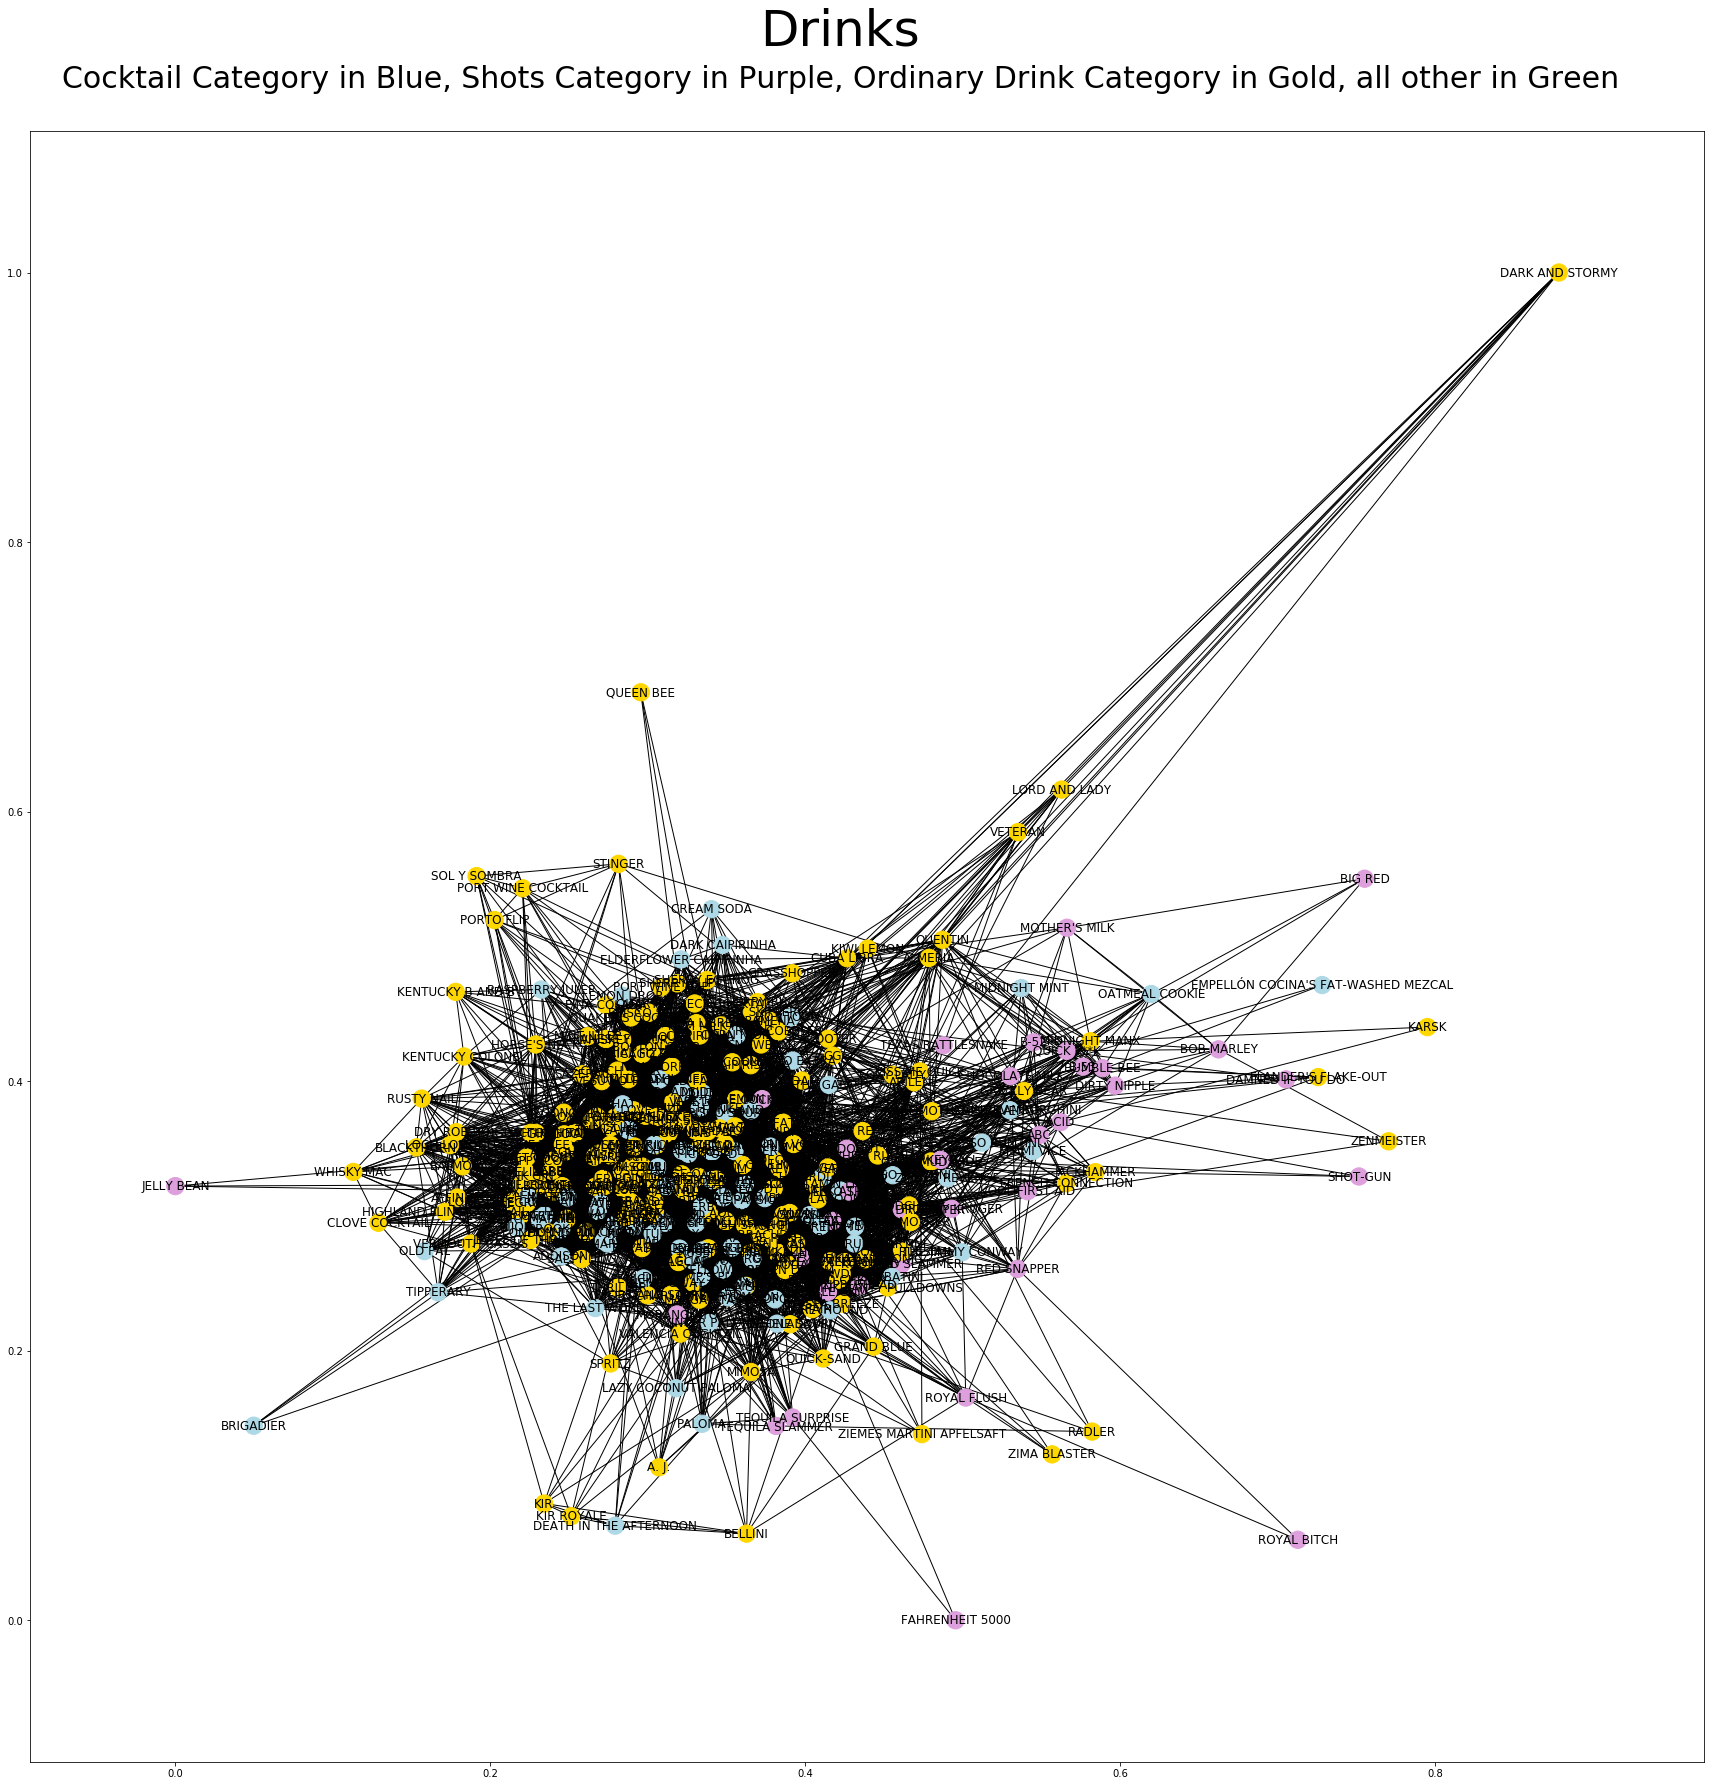

In [77]:
plt.figure(figsize = (30, 30))
ax = plt.subplot()

net.draw_networkx(D, ax=ax, node_color = colors)

plt.figtext(.5,.92,'Drinks', fontsize=50, ha='center')
plt.figtext(.5,.9, 'Cocktail Category in Blue, Shots Category in Purple, Ordinary Drink Category in Gold, all other in Green', fontsize = 30, ha='center')
plt.show()

That's challenging to interpret - so let's dig into comparing our categories by centrality measures. We'll create a summary dataframe of both degree and eigenvector centrality for all drinks across our 3 categories.

### Compare Centrality Measures across Categories
Now we're ready to compare the centrality values across our categories. We'll do this by: 
1. Create summary dataframe of both centrality measures for all drinks in our 'D' projection.
2. Get categories by drink name, and combine with the measures.
3. Look at mean values by category. 
4. Check ANOVA assumptions + conduct ANOVA analysis. 


##### 1 and 2: Prepping Summary Dataframe

In [80]:
summary_degree = pd.DataFrame.from_dict(net.degree_centrality(D), orient='index').reset_index()
summary_eigen = pd.DataFrame.from_dict(net.eigenvector_centrality(D), orient='index').reset_index()
summary_all = pd.merge(summary_degree, summary_eigen, how = "inner", on = "index")
summary_all = summary_all.rename(columns = 
        {"index":"name","0_x":"degree","0_y":"eigenvector"})
summary_all.head()

,name,degree,eigenvector
0,CHERRY RUM,0.123418,0.015696
1,WHITE RUSSIAN,0.183544,0.021771
2,LONG ISLAND TEA,0.531646,0.119156
3,ZOMBIE,0.243671,0.042716
4,LADY LOVE FIZZ,0.370253,0.120447


In [81]:
category_df = drinkDF[["name","category"]]
category_df.head()

,name,category
0,A1,Cocktail
1,ABC,Shot
2,ACE,Cocktail
3,ADAM,Ordinary Drink
4,AT&T,Ordinary Drink


In [82]:
summary_all = pd.merge(summary_all, category_df, how = "inner", on = "name")
summary_all.head()

,name,degree,eigenvector,category
0,CHERRY RUM,0.123418,0.015696,Ordinary Drink
1,WHITE RUSSIAN,0.183544,0.021771,Ordinary Drink
2,LONG ISLAND TEA,0.531646,0.119156,Ordinary Drink
3,ZOMBIE,0.243671,0.042716,Cocktail
4,LADY LOVE FIZZ,0.370253,0.120447,Ordinary Drink


##### 3: Comparing Mean and Median Values

Then we can use our summary table to compare mean and median values. We see 'Shots' has lower Degree and Eigenvector centrality, perhaps due to its lower number of ingredients.

In [85]:
grouped_summary = summary_all.groupby("category")
mean_grouped = grouped_summary.mean()
mean_grouped

,degree,eigenvector
category,,
Cocktail,0.191996,0.042552
Ordinary Drink,0.199926,0.045938
Shot,0.091400,0.010269


In [86]:
median_grouped = grouped_summary.median()
median_grouped

,degree,eigenvector
category,,
Cocktail,0.180380,0.029209
Ordinary Drink,0.183544,0.029620
Shot,0.060127,0.003270


##### 4: Check ANOVA Assumptions and Conduct ANOVA Test

ANOVA tests are useful to compare mean values across multiple categories, versus a 2-sample test for example. This analysis will tell us if our means are materially diffferent by group. 

The code below is repurposed from a tutorial [here](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b). 

Before we start the analysis, we should check our ANOVA assumptions, namely: 
- Independence, which we can assume to be true.
- Normally distributed values within each group
- Equal variances between all groups

To start, we compare a box plot across the categories. These plots suggest there are not huge differences between Cocktails and Ordinary Drinks, but a bit more difference with Shot category.

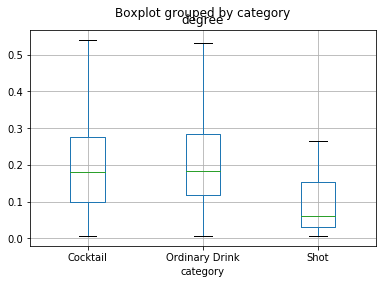

In [89]:
summary_all.boxplot('degree',by='category')

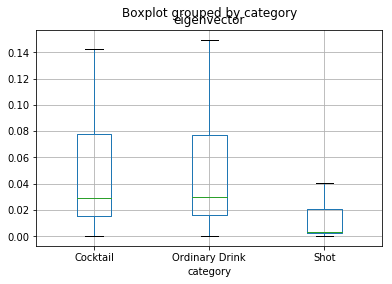

In [90]:
summary_all.boxplot('eigenvector',by='category')

First, we check for normality in both centrality metrics. We find that Degree centrality appears fairly normal, while Eigenvector is less so.

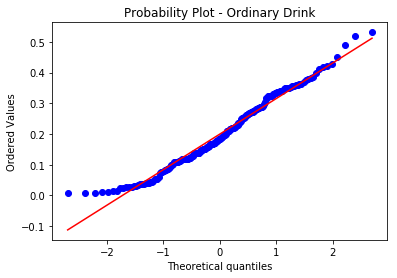

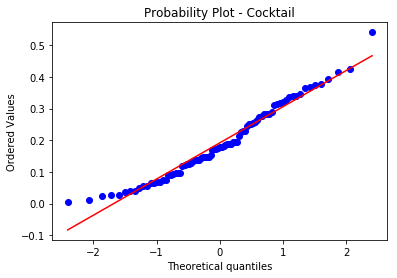

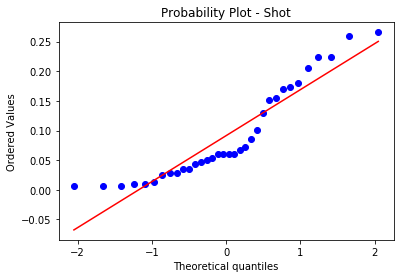

In [91]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['degree'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

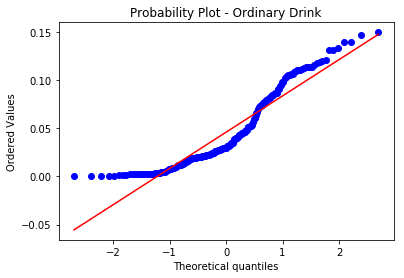

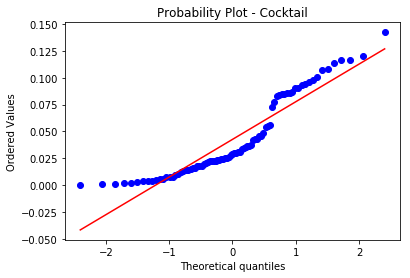

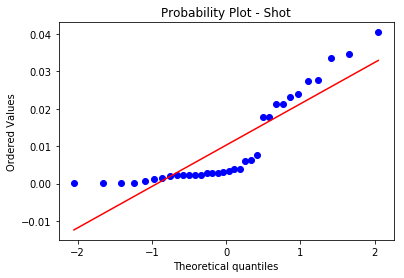

In [92]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['eigenvector'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

Then we check for the ratio of the largest and smallest standard deviation, looking for values below '2'. Eigenvector does not meet that condition, so we will take those findings directionally. 

In [93]:
ratio = summary_all.groupby('category').std().max() / summary_all.groupby('category').std().min()
ratio

degree         1.456302
eigenvector    3.273867
dtype: float64

Despite assumptions not being perfectly met, we can move forward with the analysis and exercise caution with the results. The code below follows the tutorial linked above, and creates an ANOVA table, then interprets results. 

In our case, our NULL hypothesis is that there is no difference between groups.   We conduct our test at alpha = 0.05, seeking a 95% confidence level in the results.  Since this is a two-tailed test, we need a p-value less than `alpha / 2 = 0.025` to reject the null hypothesis.

In [94]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = summary_all['degree'].mean()
SSTR = summary_all.groupby('category').count() * (summary_all.groupby('category').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['degree'].sum()

# calculate SSE and update anova table
SSE = (summary_all.groupby('category').count() - 1) * summary_all.groupby('category').std()**2
anova_table['SS']['Within Groups'] = SSE['degree'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['degree'].sum() + SSE['degree'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = summary_all['category'].nunique() - 1
anova_table['df']['Within Groups'] = summary_all.shape[0] - summary_all['category'].nunique()
anova_table['df']['Total'] = summary_all.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Print final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.345721,2,0.172861,13.702835,0.000002,3.732558
Within Groups,3.961095,314,0.012615,,,
Total,4.306816,316,0.013629,,,


In [95]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 13.702834607737707  and p value is: 1.969928075440386e-06
Null Hypothesis is rejected.


Since our p-value of 1.969928075440386e-06 is smaller than `alpha / 2`, we can reject the null hypothesis - the centrality values in this bipartite projection graph are statistically significantly different by category.

### Highest Centrality Nodes

Finally, let's look at the drinks with the highest values for each of our metrics. 

In [96]:
summary_all.sort_values(by=['degree'],ascending=False).head()

,name,degree,eigenvector,category
87,JITTERBUG,0.541139,0.142375,Cocktail
2,LONG ISLAND TEA,0.531646,0.119156,Ordinary Drink
46,LONG ISLAND ICED TEA,0.518987,0.113303,Ordinary Drink
56,RADIOACTIVE LONG ISLAND ICED TEA,0.490506,0.110504,Ordinary Drink
269,ROSE,0.449367,0.146867,Ordinary Drink


In [97]:
summary_all.sort_values(by=['eigenvector'],ascending=False).head()

,name,degree,eigenvector,category
53,GIN DAISY,0.417722,0.149664,Ordinary Drink
269,ROSE,0.449367,0.146867,Ordinary Drink
87,JITTERBUG,0.541139,0.142375,Cocktail
32,BOXCAR,0.411392,0.140020,Ordinary Drink
124,ENGLISH ROSE COCKTAIL,0.427215,0.139129,Ordinary Drink


Highest Degree and Eigenvector centrality nodes are all in the Cocktail and Ordinary categories, while Shots is not represented. This makes sense - common cocktails will have more ingredients. 

The most important cocktail by Degree centrailty is a [Jitterbug](https://www.thecocktaildb.com/drink/16178-Jitterbug). The Jitterbug contains Gin, Vodka, Grenadine, Sugar, Lime, and Simple Syrup.

![Jitterbug](https://www.thecocktaildb.com/images/media/drink/wwqvrq1441245318.jpg)

And the important cocktail by Eigenvector centrality is a [Gin Daisy](https://www.thecocktaildb.com/drink/11408-Gin-Daisy). The Gin Daisy contains Gin, Lemon Juice, Sugar, Grenadine, Cherry, and Orange.

![Gin Daisy](https://www.thecocktaildb.com/images/media/drink/z6e22f1582581155.jpg)